In [9]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [10]:
device = torch.device("cuda")

In [11]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Będziemy używać augmentacji danych

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Data augmentation
transform_augment = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 128

# Load the dataset (augment only the training set)
full_dataset_augmented = torchvision.datasets.ImageFolder(
    "./train", transform=transform_augment
)
full_dataset_clean = torchvision.datasets.ImageFolder("./train", transform=transform)

# Train:validation:test proportions
# 90% train, 10% test
num_samples = len(full_dataset_augmented)
train_size = int(0.9 * num_samples)
test_size = num_samples - train_size
# val_size = num_samples - train_size - test_size

generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(num_samples), [train_size, test_size], generator=generator
)

# Create subsets for train, validation, and test
train_data = torch.utils.data.Subset(full_dataset_augmented, train_idx)
test_data = torch.utils.data.Subset(full_dataset_clean, val_idx)
# val_data = torch.utils.data.Subset(full_dataset_clean, test_idx)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)
# validation_loader = torch.utils.data.DataLoader(
#     val_data, batch_size=batch_size, shuffle=False
# )

print(f"Train size: {len(train_loader.dataset)}")
# print(f"Test size: {len(test_loader.dataset)}")
print(f"Validation size: {len(test_loader.dataset)}")

Train size: 79209
Validation size: 8802


/home/kamil/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


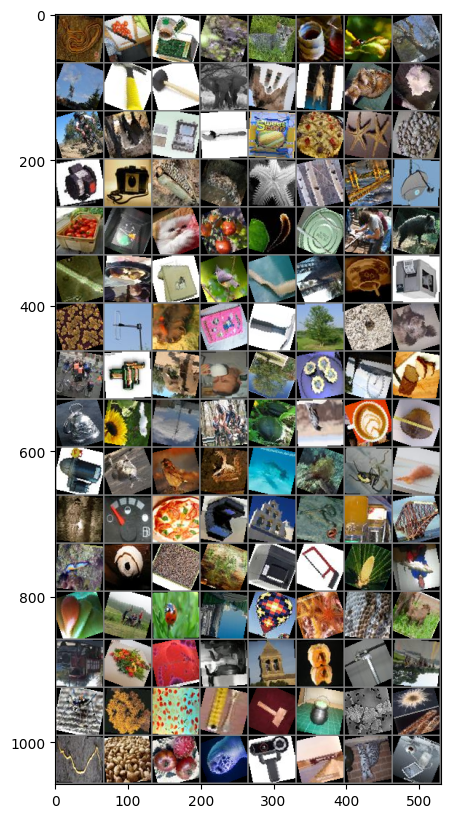

snake tomato   tea  nest   cat   tea beetle birch gauge hammer hammer elephant acoustic kangaroo   cat icecream bicycle elephant gauge spoon  corn pizza echinoderm  bean motor camera  bomb  worm echinoderm birch bridge antenna tomato gauge   cat tomato  worm  worm   saw swine bacteria   egg towel  bird  worm bridge   tea printer bacteria antenna  worm towel hammer birch  frog swine bicycle battery elephant   tea birch squash bridge bread acoustic flower antenna bicycle squash  bird   tea  crab motor kangaroo  bird  frog  fish turtle spider  fish crocodilian gauge pizza printer acoustic snake   tea bridge  worm  nest spice  worm printer   saw  palm  fish tomato bicycle beetle bridge  bomb echinoderm  nest swine truck tomato bacteria   pot acoustic squash antenna bicycle beetle flower bacteria spoon hammer   pot bacteria bacteria  worm  bean tomato turtle camera bridge   cat camera


In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

classes = full_dataset_augmented.classes

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Niezbalansowanie klas nie jest duże

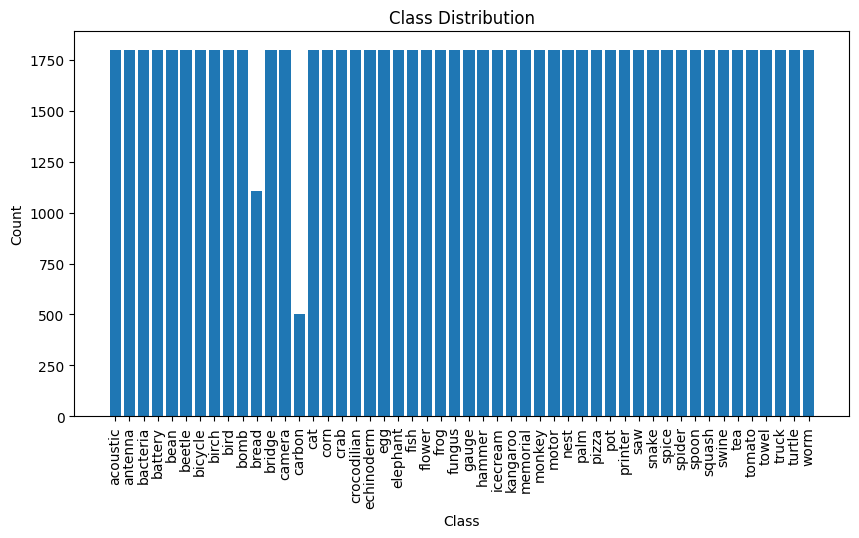

In [14]:
# Make plot of sizes of each class
class_counts = np.zeros(len(full_dataset_clean.classes))
for _, label in full_dataset_clean:
    class_counts[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), full_dataset_clean.classes, rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(256, 256, 3)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 64, 3)
        self.bn_conv5 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn_conv3(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv4(x)
        x = self.bn_conv4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn_conv5(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.fc3(x)
        
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(ker

In [16]:
# Print number of parameters
params_sum = 0
for params in net.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

1589170

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

[1/40] Train loss: 2.901
Validation loss: 2.520
Validation accuracy: 32.08%
[2/40] Train loss: 2.387
Validation loss: 2.212
Validation accuracy: 38.84%
[3/40] Train loss: 2.158
Validation loss: 2.095
Validation accuracy: 41.95%
[4/40] Train loss: 1.997
Validation loss: 1.949
Validation accuracy: 46.07%
[5/40] Train loss: 1.878
Validation loss: 1.865
Validation accuracy: 48.57%
[6/40] Train loss: 1.792
Validation loss: 1.794
Validation accuracy: 50.47%
[7/40] Train loss: 1.716
Validation loss: 1.768
Validation accuracy: 50.94%
[8/40] Train loss: 1.651
Validation loss: 1.683
Validation accuracy: 53.15%
[9/40] Train loss: 1.589
Validation loss: 1.650
Validation accuracy: 54.84%
[10/40] Train loss: 1.545
Validation loss: 1.603
Validation accuracy: 55.44%
[11/40] Train loss: 1.495
Validation loss: 1.603
Validation accuracy: 55.84%
[12/40] Train loss: 1.460
Validation loss: 1.576
Validation accuracy: 56.74%
[13/40] Train loss: 1.424
Validation loss: 1.564
Validation accuracy: 57.07%
[14/40] 

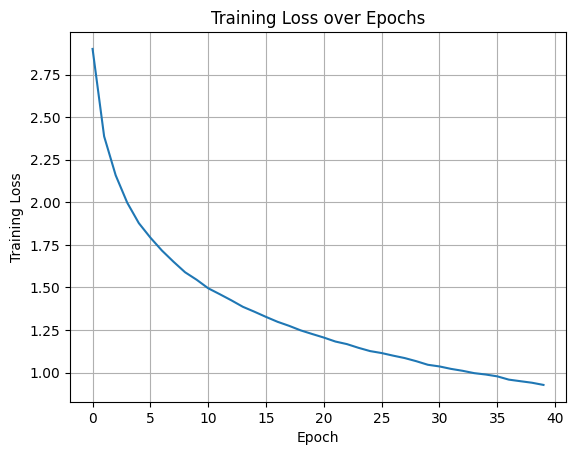

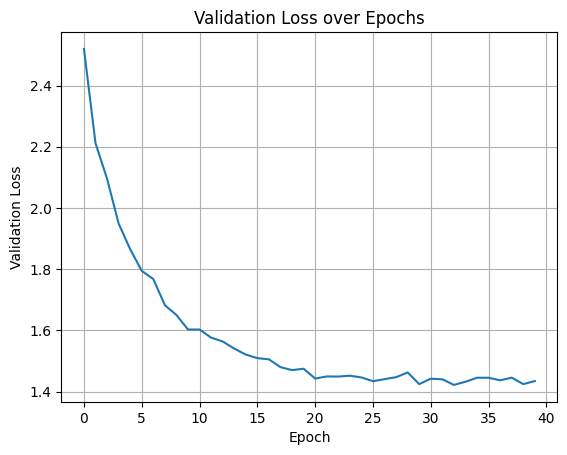

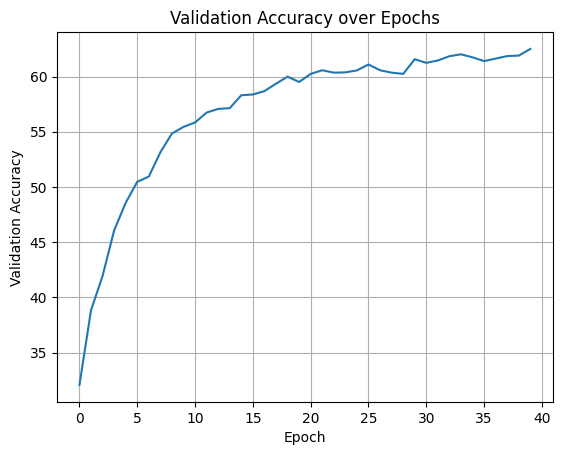

In [ ]:
max_num_epochs = 40
patience = 5

validation_losses = []
validation_accuracies = []
train_losses = []

for epoch in range(max_num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f"[%d/{max_num_epochs}] Train loss: %.3f" % (epoch + 1, running_loss))
    train_losses.append(running_loss)

    # Validation - calculate loss
    validation_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)
    validation_loss /= len(test_loader)

    # Early stopping
    if epoch > 0 and validation_loss >= validation_losses[-1] * 1.01: # minimum 1% increase
        patience -= 1

    validation_losses.append(validation_loss)
    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Validation accuracy: {validation_accuracy:.2f}%")

    if patience == 0:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Finished Training")

# Plot training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.grid()
plt.show()

# Plot validation losses
plt.plot(validation_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.grid()
plt.show()

# Plot validation accuracies
plt.plot(validation_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid()
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

Accuracy of the network on the test images: 62.50 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))


Accuracy for class acoustic is: 38.3 %
Accuracy for class antenna is: 59.8 %
Accuracy for class bacteria is: 63.8 %
Accuracy for class battery is: 51.8 %
Accuracy for class bean  is: 65.6 %
Accuracy for class beetle is: 71.2 %
Accuracy for class bicycle is: 77.7 %
Accuracy for class birch is: 60.9 %
Accuracy for class bird  is: 44.3 %
Accuracy for class bomb  is: 60.3 %
Accuracy for class bread is: 43.9 %
Accuracy for class bridge is: 59.0 %
Accuracy for class camera is: 74.4 %
Accuracy for class carbon is: 48.9 %
Accuracy for class cat   is: 71.5 %
Accuracy for class corn  is: 48.7 %
Accuracy for class crab  is: 52.6 %
Accuracy for class crocodilian is: 63.0 %
Accuracy for class echinoderm is: 67.3 %
Accuracy for class egg   is: 52.7 %
Accuracy for class elephant is: 67.0 %
Accuracy for class fish  is: 58.9 %
Accuracy for class flower is: 90.0 %
Accuracy for class frog  is: 59.0 %
Accuracy for class fungus is: 67.6 %
Accuracy for class gauge is: 56.9 %
Accuracy for class hammer is: 78

In [22]:
# Save the model
state_dict = net.state_dict()
torch.save(state_dict, "simple_model62.tar")